# Generate data based on BrainWeb images

From brainweb, get: 
- Two PET images
    - FDG
    - Amyloid
- Two MR acquisitions:
    - T1
    - T2
- A $\mu$-map

We're going to do various things with the images to create some data we can play around with! In image space, this includes:
- adding misalignment to some images (amyloid and its $\mu$-map)
- adding tumours

And then forward projecting all of this data to end up with:
- Noisy and noiseless sinograms with and without misalignment, and with and without a tumour

Acquiring the brainweb data is done via Casper da Costa-Luis' wrapper, which can be obtained with: `pip install brainweb`.

Authors: Richard Brown, Casper da Costa-Luis  
First version: 2nd of November 2019

CCP PETMR Synergistic Image Reconstruction Framework (SIRF)  
Copyright 2019  University College London  
Copyright 2019  King's College London  

This is software developed for the Collaborative Computational
Project in Positron Emission Tomography and Magnetic Resonance imaging
(http://www.ccppetmr.ac.uk/).

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
# Make sure everything is installed that we need
!pip install brainweb nibabel --user

In [2]:
from __future__ import print_function, division
%matplotlib notebook
import brainweb
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
logging.basicConfig(level=logging.INFO)
import nibabel as nib
import sirf.STIR as pet
import matplotlib.pyplot as plt
import os
import sirf.Reg as reg
from math import cos, sin, pi
from sirf.Utilities import examples_data_path
import shutil
from scipy.ndimage.filters import gaussian_filter

## Get brainweb data (just single patient)

In [3]:
data_path = path.join(examples_data_path('Synergistic'), 'brainweb')
if not path.isdir(data_path):
    os.makedirs(data_path)
os.chdir(data_path)

fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(
        f,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)
    vol_amyl = brainweb.get_mmr_fromfile(
        f,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1,
        PetClass=brainweb.Amyloid)

FDG_arr  = vol['PET']
amyl_arr = vol_amyl['PET']
uMap_arr = vol['uMap']
T1_arr   = vol['T1']
T2_arr   = vol['T2']

mMR ground truths:   0%|          | 0/1 [00:00<?, ?subject/s]

## Display it

<IPython.core.display.Javascript object>


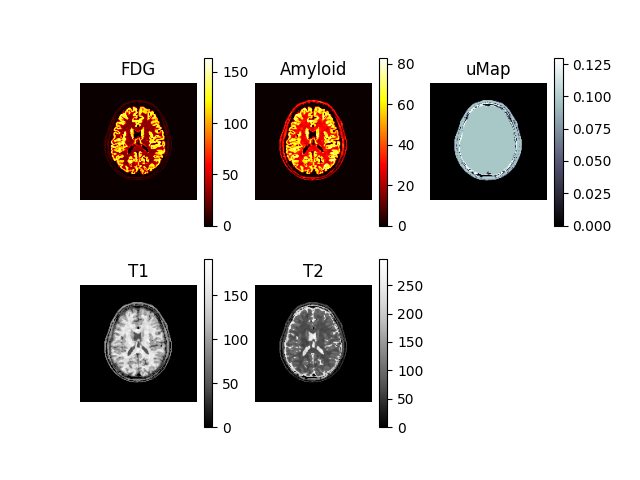

In [4]:
def subplot_(idx,vol,title,clims=None,cmap="viridis"):
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar()
    plt.title(title)
    plt.axis("off")

plt.figure();
slice_show = FDG_arr.shape[0]//2
subplot_([2,3,1],FDG_arr [slice_show, 100:-100, 100:-100],'FDG'    ,cmap="hot")
subplot_([2,3,2],amyl_arr[slice_show, 100:-100, 100:-100],'Amyloid',cmap="hot")
subplot_([2,3,3],uMap_arr[slice_show, 100:-100, 100:-100],'uMap'   ,cmap="bone")
subplot_([2,3,4],T1_arr  [slice_show, 100:-100, 100:-100],'T1'     ,cmap="Greys_r")
subplot_([2,3,5],T2_arr  [slice_show, 100:-100, 100:-100],'T2'     ,cmap="Greys_r")

## Crop images and save

Here's what's going on in this cell:

1. The data from brainweb is (127,344,344), but we want it to be (127,285,285). So just keep the middle sections of the image in the x-y plane.
2. Save the image to file.
3. Crop the image yet again to reduce it to (127,150,150). You can use either of these two sets of images, but it'll be faster to use the smaller image. We'll also apply a shift of (25,25) in the x-y plane to re-centre the image.
4. Save the smaller image to file, too.

N.B.: This requires you to have a version of SIRF > v2.1.0. See the cell at the bottom of this notebook if you have an older version of SIRF.

In [5]:
# We'll need a template sinogram
mMR_template_sino = examples_data_path('PET') + "/mMR/mMR_template_span11.hs"
templ_sino = pet.AcquisitionData(mMR_template_sino)

def crop_and_save(templ_sino, vol, fname):
    # Crop from (127,344,344) to (127,285,285) and save to file
    vol = vol[:,17:17+285,17:17+285]
    im = pet.ImageData(templ_sino)
    im.fill(vol)
    im.write(fname)
    # Create an optional smaller version, (127,150,150)
    # For extra speeeed.
    # Also shift by (25,25) in (x,y) to recentre the image
    im = im.zoom_image(size=(-1,150,150),offsets_in_mm=(0,25,25))
    im = im.move_to_scanner_centre(templ_sino)
    im.write(fname + "_small.hv")
    return im
    
FDG  = crop_and_save(templ_sino, FDG_arr,  "FDG"    )
amyl = crop_and_save(templ_sino, amyl_arr, "Amyloid")
uMap = crop_and_save(templ_sino, uMap_arr, "uMap"   )
T1   = crop_and_save(templ_sino, T1_arr,   "T1"     )
T2   = crop_and_save(templ_sino, T2_arr,   "T2"     )

<IPython.core.display.Javascript object>


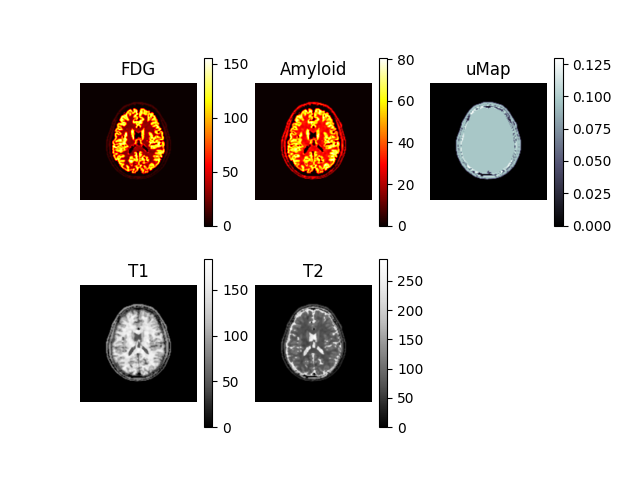

In [6]:
plt.figure();
slice_show = FDG.as_array().shape[0]//2
subplot_([2,3,1],FDG.as_array() [slice_show,:,:],'FDG'    ,cmap="hot")
subplot_([2,3,2],amyl.as_array()[slice_show,:,:],'Amyloid',cmap="hot")
subplot_([2,3,3],uMap.as_array()[slice_show,:,:],'uMap'   ,cmap="bone")
subplot_([2,3,4],T1.as_array()  [slice_show,:,:],'T1'     ,cmap="Greys_r")
subplot_([2,3,5],T2.as_array()  [slice_show,:,:],'T2'     ,cmap="Greys_r")

## Forward project

Forward project both the FDG and amyloid images both with and without Poisson noise.

In [7]:
def get_acquisition_model(uMap, templ_sino):

    #%% create acquisition model
    am = pet.AcquisitionModelUsingRayTracingMatrix()
    am.set_num_tangential_LORs(5)

    # Set up sensitivity due to attenuation
    asm_attn = pet.AcquisitionSensitivityModel(uMap, am)
    asm_attn.set_up(templ_sino)
    bin_eff = pet.AcquisitionData(templ_sino)
    bin_eff.fill(1.0)
    print('applying attenuation (please wait, may take a while)...')
    asm_attn.unnormalise(bin_eff)
    asm_attn = pet.AcquisitionSensitivityModel(bin_eff)

    am.set_acquisition_sensitivity(asm_attn)

    am.set_up(templ_sino,uMap);
    return am

In [8]:
# Function for adding noise
def add_noise(proj_data,noise_factor = 1):
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    proj_data_arr = np.abs(proj_data_arr)
    noisy_proj_data_arr = np.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr);
    return noisy_proj_data

In [9]:
am = get_acquisition_model(uMap, templ_sino)

# FDG
sino_FDG = am.forward(FDG)
sino_FDG.write("FDG_sino")
sino_FDG_noisy = add_noise(sino_FDG,1000)
sino_FDG_noisy.write("FDG_sino_noisy")

# Amyloid
sino_amyl = am.forward(amyl)
sino_amyl.write("amyl_sino")
sino_amyl_noisy = add_noise(sino_amyl,1000)
sino_amyl_noisy.write("amyl_sino_noisy")

applying attenuation (please wait, may take a while)...


<IPython.core.display.Javascript object>


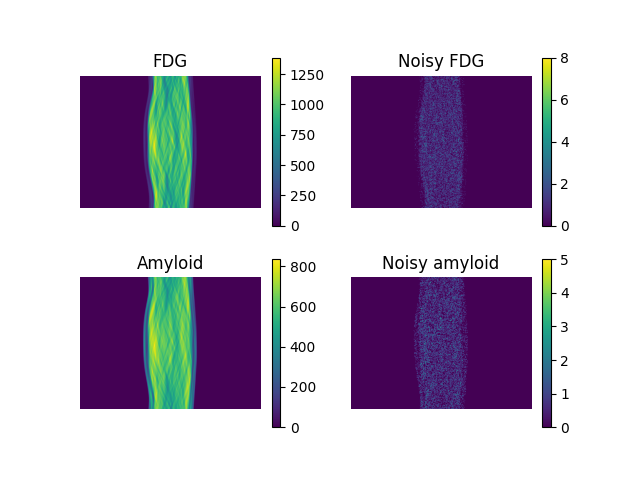

In [10]:
plt.figure();
subplot_([2,2,1],       sino_FDG.as_array()[0,60,:,:],'FDG'          )
subplot_([2,2,2], sino_FDG_noisy.as_array()[0,60,:,:],'Noisy FDG'    )
subplot_([2,2,3],      sino_amyl.as_array()[0,60,:,:],'Amyloid'      )
subplot_([2,2,4],sino_amyl_noisy.as_array()[0,60,:,:],'Noisy amyloid')

# Add misalignment to amyloid

Resample the image using SIRF's wrapper around NiftyReg. 

As with the crop, moving an image around affects its offset in STIR, which currently causes problems. So again, we recentre the image after the resample.

In [ ]:
def add_misalignment(transformation_matrix,image):

    # Resample
    resampler = reg.NiftyResample()
    resampler.set_interpolation_type_to_cubic_spline()
    resampler.set_reference_image(image)
    resampler.set_floating_image(image)
    resampler.set_padding_value(0)
    resampler.add_transformation(transformation_matrix)
    resampler.process()

    # Save to file
    resampled = resampler.get_output()

    # Remove all offset info (avoids problems in STIR)
    misaligned_image = resampled.move_to_scanner_centre(templ_sino)
    return misaligned_image

### Create the transformation matrix

The rotation matrix we'll use here is a rotation of 30 degrees about one of the axes, and a translation of 20 and -10 mm in the x- and y-directions, respectively.

In [ ]:
# Rotation matrix
r = 30*pi/180
t_x = 20
t_y = -10

tm = reg.AffineTransformation(np.array(\
        [[ cos(r), sin(r), 0, t_x], \
         [-sin(r), cos(r), 0, t_y], \
         [      0,      0, 1, 0  ], \
         [      0,      0, 0, 1  ]]))

amyl_misaligned = add_misalignment(tm,amyl)
uMap_misaligned = add_misalignment(tm,uMap)

amyl_misaligned.write("amyl_misaligned")
uMap_misaligned.write("uMap_misaligned")

# Display
def subplot_(idx,vol,title,clims=None,cmap="viridis"):
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar()
    plt.title(title)
    plt.axis("off")

plt.figure()
subplot_([2,2,1],amyl.as_array()[60,:,:],'Amyloid')
subplot_([2,2,2],uMap.as_array()[60,:,:],'uMap')
subplot_([2,2,3],amyl_misaligned.as_array()[60,:,:],'Resampled Amyloid')
subplot_([2,2,4],uMap_misaligned.as_array()[60,:,:],'Resampled uMap')

In [ ]:
# Get acquisition model for resampled data
am_misaligned = get_acquisition_model(uMap_misaligned, templ_sino)

# Forward project again
sino_amyl_misaligned = am_misaligned.forward(amyl_misaligned)
sino_amyl_misaligned.write("amyl_sino_misaligned")
sino_amyl_noisy_misaligned = add_noise(sino_amyl_misaligned,1000)
sino_amyl_noisy_misaligned.write("amyl_sino_noisy_misaligned")

In [ ]:
plt.figure()
subplot_([2,2,1],sino_amyl.as_array()[0,60,:,:],'Amyloid')
subplot_([2,2,2],sino_amyl_noisy.as_array()[0,60,:,:],'Noisy amyloid')
subplot_([2,2,3],sino_amyl_misaligned.as_array()[0,60,:,:],'Amyloid resampled')
subplot_([2,2,4],sino_amyl_noisy_misaligned.as_array()[0,60,:,:],'Noisy resampled amyloid')

# Insert tumour

We add a spherical tumour into the FDG image. Then we forward project it and add Poisson noise. The results of this aren't currently used in the notebooks, but might be in the near future. You can also use them to see the effect of differences between images when reconstructing with anatomical priors!

<IPython.core.display.Javascript object>


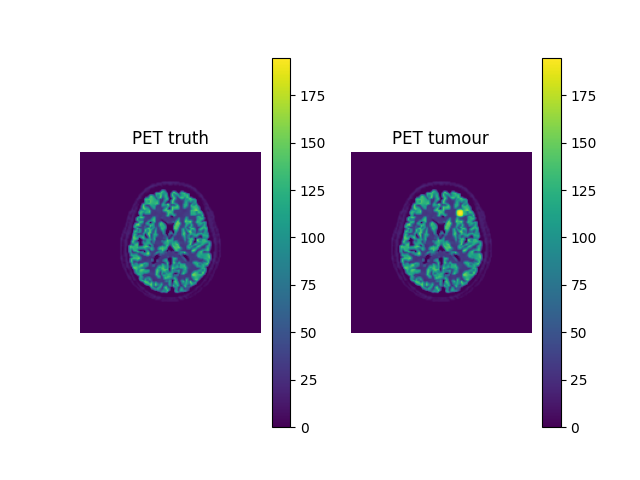

In [11]:
# Start with an image filled with zeroes. 
FDG=pet.ImageData('FDG_small.hv')
tumour_arr = FDG.get_uniform_copy(0).as_array()
# The value of the tumour will be 1.2*the max in the FDG image
tumour_val = 1.2 * FDG.as_array().max()
# Give the radius of the tumour
tumour_radius_in_voxels = 4
# Amount of smoothing
gaussian_sigma = 1
# Index of centre of the tumour
tumour_centre = np.array([60, 50, 90])
# Loop over all voxels in the cube containing the sphere
for i in range(-tumour_radius_in_voxels, tumour_radius_in_voxels):
    for j in range(-tumour_radius_in_voxels, tumour_radius_in_voxels):
        for k in range(-tumour_radius_in_voxels, tumour_radius_in_voxels):
            # If the index is inside of the sphere, set the tumour value
            if (i*i+j*j+k*k < tumour_radius_in_voxels*tumour_radius_in_voxels):
                tumour_arr[tumour_centre[0]+i,tumour_centre[1]+j,tumour_centre[2]+k] = tumour_val

# Smooth the tumour image
tumour_arr = gaussian_filter(tumour_arr, sigma=gaussian_sigma)

# Overwrite add
tumour_arr = np.max([FDG.as_array(),tumour_arr],axis=0)

# Fill into new ImageData object
pet_tumour = FDG.clone()
pet_tumour.fill(tumour_arr)
pet_tumour.write('FDG_tumour')

# Show side by side
plt.figure();
subplot_([1,2,1],FDG.as_array()[60,:,:],"PET truth", [0,tumour_arr.max()])
subplot_([1,2,2],tumour_arr[60,:,:],"PET tumour",[0,tumour_arr.max()])

## Cropping with SIRF <= v2.1.0

`zoom_image` and `move_to_scanner_centre` didn't exist prior to SIRF v2.1.0. If your version is older see this link for some help: https://github.com/SyneRBI/SIRF-Exercises/issues/52. Good luck, soldier!

In [12]:
#Forward project FDG image with tumour
umap_small=pet.ImageData('uMap_small.hv')
am = get_acquisition_model(umap_small, templ_sino)



applying attenuation (please wait, may take a while)...


In [14]:
# FDG
sino_tumour_FDG = am.forward(pet_tumour)
sino_tumour_FDG.write("FDG_tumour_sino")
sino_tumour_FDG_noisy = add_noise(sino_tumour_FDG,1000)
sino_tumour_FDG_noisy.write("FDG_tumour_sino_noisy")